## <center>Selección de Atributos en Aprendizaje de Máquina </center>

La alta dimensionalidad en un conjunto de datos puede afectar el desempeño de un sistema de reconocimiento de patrones, texto o imágenes. En otras palabras, la reducción de dimensionalidad es la transformación de un conjunto de datos con muchos atributos en un subconjunto representativo que brinde una mejor descripción de la información. La selección de atributos usado tanto en estadística y aprendizaje de máquina es una parte muy importante en el análisis de datos para identificar aquellos atributos que contribuyen o no en la exactitud de un modelo predictivo, este proceso se convierte en un factor importante sobre todo cuando el número de atributos es demasiado grande, razón por la cual no debemos usar todos los atributos que tenemos a disposición.

![best_individual](https://user-images.githubusercontent.com/7152507/91216072-fcfe3a80-e6da-11ea-99aa-c6c63c64b483.png) <center>Fuente: <a href="https://www.neuraldesigner.com/blog/genetic_algorithms_for_feature_selection">Neural Designer<a/></center>

### 1. Importación de librerías

In [2]:
import random
import json
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

### 2. Representación de un Individuo

Para representar un individuo (cromosoma) de la población, se hace uso de un cromosoma cuyos valores son binarios `(0,1)`, donde `'1'` significa que se selecciona dicho atributo y `'0'` significa que no escogemos dicho atributo para encontrar su valor de fitness. El valor de fitness representar que tan bueno es el individuo (cromosoma).

In [2]:
class Individual:
    def __init__(self, chromosome):
        self.chromosome = chromosome[:]
        self.fitness = -1

Creamos una clase para manejar los algoritmos de Cruzamiento, donde se ha implementado los algoritmos de `OnePoint` y `Uniform` con una tasa de cruzamiento de `0.5`

In [3]:
class Crossover:
    
    def __init__(self):
        self.crossover_rate = 0.5
    
    def onepoint(self, chromosome1, chromosome2):
        point = random.randrange(len(chromosome1))
        indiv1 = Individual(chromosome1[:point] + chromosome2[point:])
        indiv2 = Individual(chromosome2[:point] + chromosome1[point:])
        return [indiv1, indiv2]

    def uniform(self, chromosome1, chromosome2):
        new_chromosome1, new_chromosome2 = [], []
        for i in range(len(chromosome1)):
            if random.uniform(0, 1) < self.crossover_rate:
                new_chromosome1.append(chromosome1[i])
                new_chromosome2.append(chromosome2[i])
            else:
                new_chromosome1.append(chromosome2[i])
                new_chromosome2.append(chromosome1[i])
        
        indiv1 = Individual(new_chromosome1)
        indiv2 = Individual(new_chromosome2)
        return [indiv1, indiv2]

Creamos una clase para manejar los algoritmos de Mutación, donde se ha implementado los algoritmos de `BitFlip, BitWise e Inversion` con una tasa de mutación de `0.5`

In [4]:
class Mutation:
    
    def __init__(self):
        self.mutation_rate = 0.5
    
    def bitflip(self, chromosome):
        new_chromosome = deepcopy(chromosome)
        gene = random.randrange(0, len(new_chromosome))
        new_chromosome[gene] = 0 if new_chromosome[gene] == 1 else 1
        
        return Individual(new_chromosome)
        
    def bitwise(self, chromosome):
        new_chromosome = deepcopy(chromosome)
        for i in range(len(new_chromosome)):
            if random.uniform(0, 1) >= self.mutation_rate:
                new_chromosome[i] = 0 if new_chromosome[i] == 1 else 1
                
        return Individual(new_chromosome)
    
    def inversion(self, chromosome):
        new_chromosome = deepcopy(chromosome)
        gens = sorted(np.random.permutation(len(chromosome))[:2])
        
        partial = np.flip(new_chromosome[gens[0]:gens[1]], axis=0)
        new_chromosome[gens[0]:gens[1]] = partial
        
        return Individual(new_chromosome)

Creamos una clase para manejar los algoritmos de selección de los padres para realizar los algoritmos de Cruzamiento y Mutación. Se ha implementado los algoritmos de Roulette y Tournament.

In [5]:
class ParentSelection:
    
    def roulette(self, population):
        population_size = len(population)
        
        total_fitness = sum([individual.fitness for individual in population])
        select_fitness = random.uniform(0, total_fitness)
        
        # Seleccionamos el primer padre
        curr_fitness = 0
        for i, individual in enumerate(population):
            curr_fitness += individual.fitness
            if curr_fitness > select_fitness:
                parent1 = i
                break
        
        indiv1 = population[parent1]
        
        # Quitamos el fitnes del primer padre seleccionado
        total_fitness -= population[parent1].fitness
        select_fitness = random.uniform(0, total_fitness)
        
        # Seleccionamos el segundo padre
        curr_fitness = 0
        for i, individual in enumerate(population):
            if i == parent1: continue
            curr_fitness += individual.fitness
            if curr_fitness > select_fitness:
                parent2 = i
                break

        indiv2 = population[parent2]
        
        return (indiv1, indiv2)
    
    def tournament(self, population, tournament_size = 3):
        individuals = []
        x_indices = np.random.permutation(len(population))
        y_indices = x_indices[:tournament_size]
        
        for i in range(tournament_size):
            individuals.append(population[y_indices[i]].fitness)
        
        parent1 = np.argmax(individuals)
        indiv1 = population[x_indices[parent1]]
        
        
        individuals = []
        x_indices = np.delete(x_indices, parent1)
        x_indices = np.random.permutation(x_indices)
        y_indices = x_indices[:tournament_size]

        for i in range(tournament_size):
            individuals.append(population[y_indices[i]].fitness)
        
        parent2 = np.argmax(individuals)
        indiv2 = population[parent2]
        
        return (indiv1, indiv2)

Para la selección de sobrevivientes se realiza elitismo, es que decir que seleccionamos la misma cantidad de individuos que la generación inicial.

In [6]:
class SurvivorSelection():
    
    def ranking(self, population, offspring, num_survivors):
        next_population = []
        population.extend(offspring)
        survivors = sorted(population, key=lambda indiv: indiv.fitness, reverse=True)[:num_survivors]
        next_population = survivors
        return next_population

Para evaluar que tan bueno es un individuo, se implementa la función de fitness, en el caso específico de este proyecto, se ha usado la métrica de `accuracy_score` del modelo de Regresión Logística usando `train_test_split` de Scikit-Learn donde los atributos seleccionados son los valores en `1` de los cromosomas y son las columnas para obtener el fitness.

In [7]:
def fitness(individual, model, data):
    idx_cols = [i for i, c in enumerate(individual.chromosome) if c == 1]
    x_train, x_test, y_train, y_test = data['x_train'], data['x_test'], data['y_train'], data['y_test']
    x_train = x_train[:, idx_cols]
    x_test = x_test[:, idx_cols]
    
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    return accuracy_score(y_test, y_pred)

def create_population(population_size, chromosome_size):
    population = []
    for i in range(population_size):
        chromosome = [random.randint(0,1) for c in range(chromosome_size)]
        population.append(Individual(chromosome))
    
    return population

Creamos una clase que maneje el algoritmo genético que vamos a emplear, los parámetros necesarios para configurar son:

`population`: Indica la población inicial

`fitness`: Función de evaluación de cada individuo de nuestro algoritmo genético

`model`: Modelo a usar para evaluar sobre el conjunto de datos

`X`: Registros de nuestro conjunto de datos

`y`: Target de cada reistro del conjunto de datos

`test_size`: Valor entre [0, 1] para para dividir nuestro conjunto de datos en `train` y `test`

`do_train_test_split`: Flag para indicar si se realizará la división del conjunto de datos original, dejarlo en True.

`num_generations`: Número de generaciones por cada ejecución del algoritmo genético.

`mutation_per`: Tasa de mutación, valor entre [0, 1]

`crossover`: Algoritmo de cruzamiento, puede ser: `uniform, onepoint`

`mutation`: Algoritmo de mutación, pueder ser: `bitflip, bitwise, inversion`

`selection_parents`: Algoritmo de selección de padres, puede ser: `tournament, roulette`

`verbose`: Flag que indica si se va a mostrar el log que genera el algoritmo. Por defecto `verbose=False`

In [8]:
class GeneticAlgorithm():
    
    def __init__(self, population, fitness, model, X, y, test_size=0.33, do_train_test_split=True, 
                 num_generations=100, mutation_per=0.5, 
                 crossover='uniform', mutation='bitwise', 
                 selection_parents='tournament', verbose=False):
        
        self.model = model
        self.X = X.values
        self.columns = X.columns.values
        self.y = y
        self.test_size = test_size
        if do_train_test_split: self.__apply_train_test_split()
        self.population = population
        self.population_size = len(population)
        self.fitness = fitness
        self.num_generations = num_generations
        self.mutation_per = mutation_per
        self.crossover = crossover
        self.mutation = mutation
        self.selection_parents = selection_parents
        self.verbose = verbose
        self.best_individuals = []
        
    def __get_best_attributes(self, best_individuals):
        output = {}
        individual = sorted(best_individuals, key=lambda ind: ind.fitness, reverse=True)[:1]
        chromosome = individual[0].chromosome
        output['features']= [self.columns[i] for i in range(len(chromosome)) if chromosome[i] == 1]
        output['chromosome'] = chromosome
        output['fitness'] = individual[0].fitness
        return output
    
    def __apply_train_test_split(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, 
                                                                                self.y, 
                                                                                test_size=self.test_size) #,random_state=2020
    
    def __evaluate(self, population_eval):
        for individual in population_eval:
            if individual.fitness == -1:
                data = {'x_train': self.X_train, 'x_test': self.X_test,
                        'y_train': self.y_train, 'y_test': self.y_test }
                individual.fitness = self.fitness(individual, self.model, data)
    
    def optimize(self):    
        # Creamos Crossover
        crossover = Crossover()
        # Creamos Mutación
        mutation = Mutation()
        # Creamos Parent Selection
        parent_selection = ParentSelection()
        # Creamos Survivor Selection
        survivor_selection = SurvivorSelection()
        
        # Paso 0: Evaluar la primera generación
        self.__evaluate(self.population)
        best_individual = sorted(self.population, key=lambda individual: individual.fitness, reverse=True)[:1]
        self.best_individuals.append(best_individual[0])
        
        if self.verbose:
            print(f'Generción: Inicial')
            print(f'Mejor Individuo: {best_individual[0].chromosome}\nFitness: {best_individual[0].fitness}')
        
        for generation in range(self.num_generations):
            # Paso 1: Selección de padres
            mating_pool = []
            for i in range(int(self.population_size / 2)):
                if self.selection_parents == 'roulette':
                    mating_pool.append(parent_selection.roulette(self.population))
                elif self.selection_parents == 'tournament':
                    mating_pool.append(parent_selection.tournament(self.population))
                else:
                    raise NotImplementedError
            
            # Paso 2: Cruzamiento de cromosomas
            offspring_population = []
            for i in range(len(mating_pool)):
                if self.crossover == 'onepoint':
                    offspring_population.extend(crossover.onepoint(mating_pool[i][0].chromosome, mating_pool[i][1].chromosome))
                elif self.crossover == 'uniform':
                    offspring_population.extend(crossover.uniform(mating_pool[i][0].chromosome, mating_pool[i][1].chromosome))
                    pass
                else:
                    raise NotImplementedError
            
            # Paso 3: Mutación de cromosomas
            for i in range(len(offspring_population)):
                if random.uniform(0, 1) < self.mutation_per:
                    if self.mutation == 'bitflip':
                        offspring_population[i] == mutation.bitflip(offspring_population[i].chromosome)
                    elif self.mutation == 'bitwise':
                        offspring_population[i] == mutation.bitwise(offspring_population[i].chromosome)
                    elif self.mutation == 'inversion':
                        offspring_population[i] == mutation.inversion(offspring_population[i].chromosome)
                    else:
                        raise NotImplementedError
            
            # Paso 4: Evaluamos la nueva descendencia
            self.__evaluate(offspring_population)
            best_individual = sorted(self.population, key=lambda individual: individual.fitness, reverse=True)[:1]
            self.best_individuals.append(best_individual[0])
        
            if self.verbose and (generation % 10 == 0):
                print(f'Generción: {1 if generation == 0 else generation}')
                print(f'Mejor Individuo: {best_individual[0].chromosome}\nFitness: {best_individual[0].fitness}')
        
            # Paso 5: Seleccionamos los nuevos individuos para la sgte. generación
            # Sólo se ha implementado por 'ranking', por lo cual se hace de manera directa
            self.population = survivor_selection.ranking(self.population, offspring_population, self.population_size)
            
            
        return self.__get_best_attributes(self.best_individuals)

### 3. Lectura del conjunto de datos

Leemos el conjunto de datos que se llama `bank-full.csv`, se puede encontrar en <a href='https://archive.ics.uci.edu/ml/datasets/Bank+Marketing'>Bank Marketing Dataset</a>

In [9]:
dataset = pd.read_csv('dataset/bank-full.csv', sep=";")

In [11]:
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### 2. Pre-procesamiento del conjunto de datos

El pre-procesamiento que se realiza es sencillo, ya que la idea es ver que resultados obtenemos del subconjunto de atributos encontrado por el algoritmo genético.

In [12]:
# 2.1. LabelEnconder
encoder = LabelEncoder()

In [13]:
# Codificamos los valores categoricos
def convert_categorical_to_codes(X):
    X_new = X.copy()
    for c in X_new:
        if pd.api.types.is_object_dtype(X_new[c]) == True:
            X_new[c] = encoder.fit_transform(X_new[c])
    return X_new

def preprocessing(X):
    X_new = X.copy()
    X_new = X_new[X_new['education'] != 'unknown']
    X_new = X_new[X_new['contact'] != 'unknown']
    X_new = X_new[X_new['job'] != 'unknown']
    X_new = convert_categorical_to_codes(X_new)
    return X_new

def replace_values_outliers(X, column, max_value):
    X_new = X.copy()
    stat = X_new[column].describe()
    values = X_new[column].values
    X_new[column] = np.where(np.logical_or(values < stat['min'], values > max_value), stat['mean'], values)
    return X_new

In [14]:
X = preprocessing(dataset)

### 4. Tratamiento de Outliers

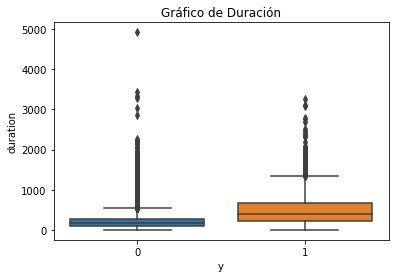

In [15]:
sns.boxplot(x='y', y='duration', data=X)
plt.title('Gráfico de Duración')
plt.show()

In [16]:
X = replace_values_outliers(X, 'duration', 1500)

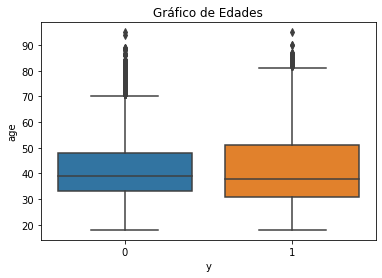

In [17]:
sns.boxplot(x='y', y='age', data=X)
plt.title('Gráfico de Edades')
plt.show()

In [18]:
X = replace_values_outliers(X, 'age', 80)

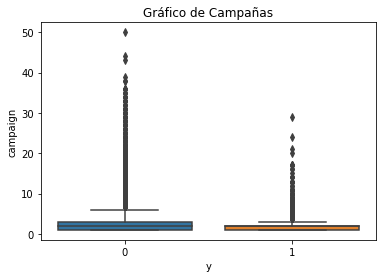

In [19]:
sns.boxplot(x='y', y='campaign', data=X)
plt.title('Gráfico de Campañas')
plt.show()

In [20]:
X = replace_values_outliers(X, 'campaign', 7)

In [21]:
X.reset_index(drop=True, inplace=True)
y = X['y']
X = X.drop(['y'], axis=1)

### 5. Escalamiento de Datos

In [22]:
# 3.1. StandardScaler
scaler = StandardScaler()
X_scale = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns) 

### 6. Ejecutamos la Técnica base

La técnica base que se ha escogido es el uso de Regresión Logística, con un total de `10 ejecuciones` para encontrar el mejor `score` el que lo compararemos sobre los resultado que encontremos con el algoritmo genético.

In [96]:
scores = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.33)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
idx = np.argmax(scores)
print("Score del modelo usando todos los atributos: ", round(scores[idx]*100,4),'%' )

Score del modelo usando todos los atributos:  86.4412 %


In [119]:
base_line = {}
base_line['base_line'] = [{ 'features': X_train.columns.tolist(), 
              'chromosomes': [1 for i in range(X_train.shape[1])],
              'fitness': score } for score in scores]

### 7. Ejecutamos el Algoritmo Genético

Esta parte de experimentación con el algoritmo genético consta de 12 ejecuciones con distintos parámetros para encontrar aquel que nos brinda los mejores resultados en comparación a la Técnica base.

In [25]:
model = LogisticRegression()
all_runs = {}
best_values = []

for i in range(10):
    print("Ejecución: ", i)
    initial_population = create_population(population_size=50, chromosome_size=X.shape[1])
    ga = GeneticAlgorithm(deepcopy(initial_population), fitness, model, 
                          X_scale, y, test_size=0.33, do_train_test_split=True,
                          num_generations=100, mutation_per=.0, crossover='uniform',
                          mutation='bitflip', selection_parents='roulette', verbose=False)
    
    output = ga.optimize()
    best_values.append(output)

    
all_runs['config_1'] = best_values
best_values_sorted = sorted(best_values, key=lambda v: v['fitness'], reverse=True)
print("Lista de atributos originales\n\n", ga.columns, "\n")
print("*"*80)
print("")
for i, indiv in enumerate(best_values_sorted[:3]):
    print(f"Individio {i+1}")
    print("Cromosomas:",indiv['chromosome'])
    print("Atributos:", indiv['features'])
    print("Fitness:", round(indiv['fitness']*100, 4), '%')
    print("\n")

Ejecución:  0
Ejecución:  1
Ejecución:  2
Ejecución:  3
Ejecución:  4
Ejecución:  5
Ejecución:  6
Ejecución:  7
Ejecución:  8
Ejecución:  9
Lista de atributos originales

 ['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome'] 

********************************************************************************

Individio 1
Cromosomas: [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1]
Atributos: ['marital', 'education', 'balance', 'housing', 'month', 'duration', 'pdays', 'poutcome']
Fitness: 87.1373 %


Individio 2
Cromosomas: [1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
Atributos: ['age', 'marital', 'education', 'balance', 'housing', 'day', 'month', 'duration', 'campaign', 'pdays', 'poutcome']
Fitness: 87.0294 %


Individio 3
Cromosomas: [1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1]
Atributos: ['age', 'job', 'education', 'default', 'housing', 'duration', 'pdays', 'previous', 'poutcome']


In [26]:
model = LogisticRegression()
best_values = []

for i in range(10):
    print("Ejecución: ", i)
    initial_population = create_population(population_size=50, chromosome_size=X.shape[1])
    ga = GeneticAlgorithm(deepcopy(initial_population), fitness, model, 
                          X_scale, y, test_size=0.33, do_train_test_split=True,
                          num_generations=100, mutation_per=0.5, crossover='uniform',
                          mutation='bitflip', selection_parents='roulette', verbose=False)
    
    output = ga.optimize()
    best_values.append(output)

    
all_runs['config_2'] = best_values
best_values_sorted = sorted(best_values, key=lambda v: v['fitness'], reverse=True)
print("Lista de atributos originales\n\n", ga.columns, "\n")
print("*"*80)
print("")
for i, indiv in enumerate(best_values_sorted[:3]):
    print(f"Individio {i+1}")
    print("Cromosomas:",indiv['chromosome'])
    print("Atributos:", indiv['features'])
    print("Fitness:", round(indiv['fitness']*100, 4), '%')
    print("\n")

Ejecución:  0
Ejecución:  1
Ejecución:  2
Ejecución:  3
Ejecución:  4
Ejecución:  5
Ejecución:  6
Ejecución:  7
Ejecución:  8
Ejecución:  9
Lista de atributos originales

 ['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome'] 

********************************************************************************

Individio 1
Cromosomas: [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1]
Atributos: ['age', 'job', 'marital', 'education', 'default', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'poutcome']
Fitness: 87.0196 %


Individio 2
Cromosomas: [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1]
Atributos: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'poutcome']
Fitness: 87.0098 %


Individio 3
Cromosomas: [1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
Atributos: ['age', 'marital', 'education', 'default', 'balance', 'housi

In [27]:
model = LogisticRegression()
best_values = []

for i in range(10):
    print("Ejecución: ", i)
    initial_population = create_population(population_size=50, chromosome_size=X.shape[1])
    ga = GeneticAlgorithm(deepcopy(initial_population), fitness, model, 
                          X_scale, y, test_size=0.33, do_train_test_split=True,
                          num_generations=100, mutation_per=0.75, crossover='uniform',
                          mutation='bitflip', selection_parents='roulette', verbose=False)
    
    output = ga.optimize()
    best_values.append(output)

    
all_runs['config_3'] = best_values
best_values_sorted = sorted(best_values, key=lambda v: v['fitness'], reverse=True)
print("Lista de atributos originales\n\n", ga.columns, "\n")
print("*"*80)
print("")
for i, indiv in enumerate(best_values_sorted[:3]):
    print(f"Individio {i+1}")
    print("Cromosomas:",indiv['chromosome'])
    print("Atributos:", indiv['features'])
    print("Fitness:", round(indiv['fitness']*100, 4), '%')
    print("\n")

Ejecución:  0
Ejecución:  1
Ejecución:  2
Ejecución:  3
Ejecución:  4
Ejecución:  5
Ejecución:  6
Ejecución:  7
Ejecución:  8
Ejecución:  9
Lista de atributos originales

 ['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome'] 

********************************************************************************

Individio 1
Cromosomas: [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Atributos: ['age', 'job', 'marital', 'education', 'default', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
Fitness: 87.1176 %


Individio 2
Cromosomas: [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Atributos: ['education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
Fitness: 87.0784 %


Individio 3
Cromosomas: [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1]
Atributos: ['marital', 'education', 'housing', 'month', 'du

In [28]:
model = LogisticRegression()
best_values = []

for i in range(10):
    print("Ejecución: ", i)
    initial_population = create_population(population_size=50, chromosome_size=X.shape[1])
    ga = GeneticAlgorithm(deepcopy(initial_population), fitness, model, 
                          X_scale, y, test_size=0.33, do_train_test_split=True,
                          num_generations=100, mutation_per=0., crossover='uniform',
                          mutation='bitwise', selection_parents='tournament', verbose=False)
    
    output = ga.optimize()
    best_values.append(output)

    
all_runs['config_4'] = best_values
best_values_sorted = sorted(best_values, key=lambda v: v['fitness'], reverse=True)
print("Lista de atributos originales\n\n", ga.columns, "\n")
print("*"*80)
print("")
for i, indiv in enumerate(best_values_sorted[:3]):
    print(f"Individio {i+1}")
    print("Cromosomas:",indiv['chromosome'])
    print("Atributos:", indiv['features'])
    print("Fitness:", round(indiv['fitness']*100, 4), '%')
    print("\n")

Ejecución:  0
Ejecución:  1
Ejecución:  2
Ejecución:  3
Ejecución:  4
Ejecución:  5
Ejecución:  6
Ejecución:  7
Ejecución:  8
Ejecución:  9
Lista de atributos originales

 ['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome'] 

********************************************************************************

Individio 1
Cromosomas: [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
Atributos: ['age', 'education', 'housing', 'duration', 'campaign', 'pdays', 'poutcome']
Fitness: 87.1569 %


Individio 2
Cromosomas: [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1]
Atributos: ['age', 'marital', 'education', 'default', 'housing', 'loan', 'day', 'duration', 'campaign', 'pdays', 'poutcome']
Fitness: 87.0294 %


Individio 3
Cromosomas: [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1]
Atributos: ['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'poutc

In [29]:
model = LogisticRegression()
best_values = []

for i in range(10):
    print("Ejecución: ", i)
    initial_population = create_population(population_size=50, chromosome_size=X.shape[1])
    ga = GeneticAlgorithm(deepcopy(initial_population), fitness, model, 
                          X_scale, y, test_size=0.33, do_train_test_split=True,
                          num_generations=100, mutation_per=0.5, crossover='uniform',
                          mutation='bitwise', selection_parents='tournament', verbose=False)
    
    output = ga.optimize()
    best_values.append(output)

    
all_runs['config_5'] = best_values
best_values_sorted = sorted(best_values, key=lambda v: v['fitness'], reverse=True)
print("Lista de atributos originales\n\n", ga.columns, "\n")
print("*"*80)
print("")
for i, indiv in enumerate(best_values_sorted[:3]):
    print(f"Individio {i+1}")
    print("Cromosomas:",indiv['chromosome'])
    print("Atributos:", indiv['features'])
    print("Fitness:", round(indiv['fitness']*100, 4), '%')
    print("\n")

Ejecución:  0
Ejecución:  1
Ejecución:  2
Ejecución:  3
Ejecución:  4
Ejecución:  5
Ejecución:  6
Ejecución:  7
Ejecución:  8
Ejecución:  9
Lista de atributos originales

 ['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome'] 

********************************************************************************

Individio 1
Cromosomas: [0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
Atributos: ['default', 'housing', 'loan', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
Fitness: 87.3137 %


Individio 2
Cromosomas: [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1]
Atributos: ['job', 'education', 'default', 'housing', 'day', 'month', 'duration', 'pdays', 'previous', 'poutcome']
Fitness: 87.1275 %


Individio 3
Cromosomas: [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Atributos: ['age', 'job', 'education', 'housing', 'contact', 'day', 'duration', 'pdays']
Fitness: 86.8

In [30]:
model = LogisticRegression()
best_values = []

for i in range(10):
    print("Ejecución: ", i)
    initial_population = create_population(population_size=50, chromosome_size=X.shape[1])
    ga = GeneticAlgorithm(deepcopy(initial_population), fitness, model, 
                          X_scale, y, test_size=0.33, do_train_test_split=True,
                          num_generations=100, mutation_per=0.75, crossover='uniform',
                          mutation='bitwise', selection_parents='tournament', verbose=False)
    
    output = ga.optimize()
    best_values.append(output)

    
all_runs['config_6'] = best_values
best_values_sorted = sorted(best_values, key=lambda v: v['fitness'], reverse=True)
print("Lista de atributos originales\n\n", ga.columns, "\n")
print("*"*80)
print("")
for i, indiv in enumerate(best_values_sorted[:3]):
    print(f"Individio {i+1}")
    print("Cromosomas:",indiv['chromosome'])
    print("Atributos:", indiv['features'])
    print("Fitness:", round(indiv['fitness']*100, 4), '%')
    print("\n")

Ejecución:  0
Ejecución:  1
Ejecución:  2
Ejecución:  3
Ejecución:  4
Ejecución:  5
Ejecución:  6
Ejecución:  7
Ejecución:  8
Ejecución:  9
Lista de atributos originales

 ['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome'] 

********************************************************************************

Individio 1
Cromosomas: [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Atributos: ['job', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous']
Fitness: 86.8824 %


Individio 2
Cromosomas: [1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]
Atributos: ['age', 'marital', 'education', 'housing', 'loan', 'contact', 'day', 'duration', 'pdays', 'poutcome']
Fitness: 86.7941 %


Individio 3
Cromosomas: [1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1]
Atributos: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'duration', 'pdays', 

In [31]:
model = LogisticRegression()
best_values = []

for i in range(10):
    print("Ejecución: ", i)
    initial_population = create_population(population_size=50, chromosome_size=X.shape[1])
    ga = GeneticAlgorithm(deepcopy(initial_population), fitness, model, 
                          X_scale, y, test_size=0.33, do_train_test_split=True,
                          num_generations=100, mutation_per=.0, crossover='onepoint',
                          mutation='inversion', selection_parents='roulette', verbose=False)
    
    output = ga.optimize()
    best_values.append(output)

    
all_runs['config_7'] = best_values
best_values_sorted = sorted(best_values, key=lambda v: v['fitness'], reverse=True)
print("Lista de atributos originales\n\n", ga.columns, "\n")
print("*"*80)
print("")
for i, indiv in enumerate(best_values_sorted[:3]):
    print(f"Individio {i+1}")
    print("Cromosomas:",indiv['chromosome'])
    print("Atributos:", indiv['features'])
    print("Fitness:", round(indiv['fitness']*100, 4), '%')
    print("\n")

Ejecución:  0
Ejecución:  1
Ejecución:  2
Ejecución:  3
Ejecución:  4
Ejecución:  5
Ejecución:  6
Ejecución:  7
Ejecución:  8
Ejecución:  9
Lista de atributos originales

 ['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome'] 

********************************************************************************

Individio 1
Cromosomas: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]
Atributos: ['age', 'marital', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
Fitness: 86.902 %


Individio 2
Cromosomas: [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]
Atributos: ['age', 'job', 'marital', 'default', 'housing', 'contact', 'day', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
Fitness: 86.8137 %


Individio 3
Cromosomas: [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
Atributos: ['age', 'marital', 'education', 'housing', 'conta

In [38]:
model = LogisticRegression()
best_values = []

for i in range(10):
    print("Ejecución: ", i)
    initial_population = create_population(population_size=50, chromosome_size=X.shape[1])
    ga = GeneticAlgorithm(deepcopy(initial_population), fitness, model, 
                          X_scale, y, test_size=0.33, do_train_test_split=True,
                          num_generations=100, mutation_per=.5, crossover='onepoint',
                          mutation='inversion', selection_parents='roulette', verbose=False)
    
    output = ga.optimize()
    best_values.append(output)

    
all_runs['config_8'] = best_values
best_values_sorted = sorted(best_values, key=lambda v: v['fitness'], reverse=True)
print("Lista de atributos originales\n\n", ga.columns, "\n")
print("*"*80)
print("")
for i, indiv in enumerate(best_values_sorted[:3]):
    print(f"Individio {i+1}")
    print("Cromosomas:",indiv['chromosome'])
    print("Atributos:", indiv['features'])
    print("Fitness:", round(indiv['fitness']*100, 4), '%')
    print("\n")

Ejecución:  0
Ejecución:  1
Ejecución:  2
Ejecución:  3
Ejecución:  4
Ejecución:  5
Ejecución:  6
Ejecución:  7
Ejecución:  8
Ejecución:  9
Lista de atributos originales

 ['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome'] 

********************************************************************************

Individio 1
Cromosomas: [0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
Atributos: ['education', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'pdays', 'previous', 'poutcome']
Fitness: 87.1176 %


Individio 2
Cromosomas: [1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
Atributos: ['age', 'marital', 'education', 'balance', 'housing', 'loan', 'contact', 'day', 'duration', 'campaign', 'pdays', 'poutcome']
Fitness: 87.0196 %


Individio 3
Cromosomas: [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Atributos: ['marital', 'default', 'balance', 'housing', 'duration', 'pdays', 'po

In [39]:
model = LogisticRegression()
best_values = []

for i in range(10):
    print("Ejecución: ", i)
    initial_population = create_population(population_size=50, chromosome_size=X.shape[1])
    ga = GeneticAlgorithm(deepcopy(initial_population), fitness, model, 
                          X_scale, y, test_size=0.33, do_train_test_split=True,
                          num_generations=100, mutation_per=.75, crossover='onepoint',
                          mutation='inversion', selection_parents='roulette', verbose=False)
    
    output = ga.optimize()
    best_values.append(output)

    
all_runs['config_9'] = best_values
best_values_sorted = sorted(best_values, key=lambda v: v['fitness'], reverse=True)
print("Lista de atributos originales\n\n", ga.columns, "\n")
print("*"*80)
print("")
for i, indiv in enumerate(best_values_sorted[:3]):
    print(f"Individio {i+1}")
    print("Cromosomas:",indiv['chromosome'])
    print("Atributos:", indiv['features'])
    print("Fitness:", round(indiv['fitness']*100, 4), '%')
    print("\n")

Ejecución:  0
Ejecución:  1
Ejecución:  2
Ejecución:  3
Ejecución:  4
Ejecución:  5
Ejecución:  6
Ejecución:  7
Ejecución:  8
Ejecución:  9
Lista de atributos originales

 ['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome'] 

********************************************************************************

Individio 1
Cromosomas: [1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1]
Atributos: ['age', 'marital', 'default', 'contact', 'day', 'duration', 'pdays', 'poutcome']
Fitness: 87.4804 %


Individio 2
Cromosomas: [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Atributos: ['marital', 'education', 'default', 'housing', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
Fitness: 87.0098 %


Individio 3
Cromosomas: [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]
Atributos: ['age', 'education', 'housing', 'loan', 'contact', 'day', 'duration', 'pdays', 'poutcome']
Fitness: 86.8922 %




In [27]:
model = LogisticRegression()
best_values = []

for i in range(10):
    print("Ejecución: ", i)
    initial_population = create_population(population_size=50, chromosome_size=X.shape[1])
    ga = GeneticAlgorithm(deepcopy(initial_population), fitness, model, 
                          X_scale, y, test_size=0.33, do_train_test_split=True,
                          num_generations=100, mutation_per=.0, crossover='onepoint',
                          mutation='bitflip', selection_parents='tournament', verbose=False)
    
    output = ga.optimize()
    best_values.append(output)

    
all_runs['config_10'] = best_values
best_values_sorted = sorted(best_values, key=lambda v: v['fitness'], reverse=True)
print("Lista de atributos originales\n\n", ga.columns, "\n")
print("*"*80)
print("")
for i, indiv in enumerate(best_values_sorted[:3]):
    print(f"Individio {i+1}")
    print("Cromosomas:",indiv['chromosome'])
    print("Atributos:", indiv['features'])
    print("Fitness:", round(indiv['fitness']*100, 4), '%')
    print("\n")

Ejecución:  0
Ejecución:  1
Ejecución:  2
Ejecución:  3
Ejecución:  4
Ejecución:  5
Ejecución:  6
Ejecución:  7
Ejecución:  8
Ejecución:  9
Lista de atributos originales

 ['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome'] 

********************************************************************************

Individio 1
Cromosomas: [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]
Atributos: ['age', 'job', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'duration', 'pdays', 'poutcome']
Fitness: 86.7843 %


Individio 2
Cromosomas: [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]
Atributos: ['age', 'marital', 'education', 'housing', 'contact', 'day', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
Fitness: 86.7157 %


Individio 3
Cromosomas: [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]
Atributos: ['age', 'job', 'marital', 'education', 'default', 'loan', 'da

In [31]:
model = LogisticRegression()
best_values = []

for i in range(10):
    print("Ejecución: ", i)
    initial_population = create_population(population_size=50, chromosome_size=X.shape[1])
    ga = GeneticAlgorithm(deepcopy(initial_population), fitness, model, 
                          X_scale, y, test_size=0.33, do_train_test_split=True,
                          num_generations=100, mutation_per=.5, crossover='onepoint',
                          mutation='bitflip', selection_parents='tournament', verbose=False)
    
    output = ga.optimize()
    best_values.append(output)

    
all_runs['config_11'] = best_values
best_values_sorted = sorted(best_values, key=lambda v: v['fitness'], reverse=True)
print("Lista de atributos originales\n\n", ga.columns, "\n")
print("*"*80)
print("")
for i, indiv in enumerate(best_values_sorted[:3]):
    print(f"Individio {i+1}")
    print("Cromosomas:",indiv['chromosome'])
    print("Atributos:", indiv['features'])
    print("Fitness:", round(indiv['fitness']*100, 4), '%')
    print("\n")

Ejecución:  0
Ejecución:  1
Ejecución:  2
Ejecución:  3
Ejecución:  4
Ejecución:  5
Ejecución:  6
Ejecución:  7
Ejecución:  8
Ejecución:  9
Lista de atributos originales

 ['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome'] 

********************************************************************************

Individio 1
Cromosomas: [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1]
Atributos: ['age', 'job', 'education', 'default', 'housing', 'day', 'month', 'duration', 'pdays', 'poutcome']
Fitness: 86.9902 %


Individio 2
Cromosomas: [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]
Atributos: ['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan', 'contact', 'day', 'duration', 'pdays', 'poutcome']
Fitness: 86.7745 %


Individio 3
Cromosomas: [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
Atributos: ['marital', 'education', 'housing', 'month', 'duration', 'campaign', 'pdays', 'p

In [28]:
model = LogisticRegression()
best_values = []

for i in range(10):
    print("Ejecución: ", i)
    initial_population = create_population(population_size=50, chromosome_size=X.shape[1])
    ga = GeneticAlgorithm(deepcopy(initial_population), fitness, model, 
                          X_scale, y, test_size=0.33, do_train_test_split=True,
                          num_generations=100, mutation_per=.75, crossover='onepoint',
                          mutation='bitflip', selection_parents='tournament', verbose=False)
    
    output = ga.optimize()
    best_values.append(output)

    
all_runs['config_12'] = best_values
best_values_sorted = sorted(best_values, key=lambda v: v['fitness'], reverse=True)
print("Lista de atributos originales\n\n", ga.columns, "\n")
print("*"*80)
print("")
for i, indiv in enumerate(best_values_sorted[:3]):
    print(f"Individio {i+1}")
    print("Cromosomas:",indiv['chromosome'])
    print("Atributos:", indiv['features'])
    print("Fitness:", round(indiv['fitness']*100, 4), '%')
    print("\n")

Ejecución:  0
Ejecución:  1
Ejecución:  2
Ejecución:  3
Ejecución:  4
Ejecución:  5
Ejecución:  6
Ejecución:  7
Ejecución:  8
Ejecución:  9
Lista de atributos originales

 ['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome'] 

********************************************************************************

Individio 1
Cromosomas: [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]
Atributos: ['age', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'duration', 'pdays', 'poutcome']
Fitness: 87.0 %


Individio 2
Cromosomas: [1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]
Atributos: ['age', 'job', 'education', 'default', 'housing', 'contact', 'day', 'month', 'duration', 'pdays', 'poutcome']
Fitness: 86.9314 %


Individio 3
Cromosomas: [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
Atributos: ['education', 'balance', 'housing', 'duration', 'campaign', 'pdays', 'poutcome']
Fitness: 

In [11]:
all_runs.update(base_line)

for key,value in all_runs.items():
    sorted_data = sorted(value, key=lambda conf: conf['fitness'], reverse=True)
    config = sorted_data[0]
    print(key,'\n', config['features'], '\n', config['fitness'], '\n')

config_1 
 ['marital', 'education', 'balance', 'housing', 'month', 'duration', 'pdays', 'poutcome'] 
 0.8713725490196078 

config_2 
 ['age', 'job', 'marital', 'education', 'default', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'poutcome'] 
 0.8701960784313726 

config_3 
 ['age', 'job', 'marital', 'education', 'default', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome'] 
 0.8711764705882353 

config_4 
 ['age', 'education', 'housing', 'duration', 'campaign', 'pdays', 'poutcome'] 
 0.8715686274509804 

config_5 
 ['default', 'housing', 'loan', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome'] 
 0.8731372549019608 

config_6 
 ['job', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous'] 
 0.8688235294117647 

config_7 
 ['age', 'marital', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome'] 
 0.8690196078431373 

config_8 
 ['educati

### 4. Visualizamos Gráfica de fitness

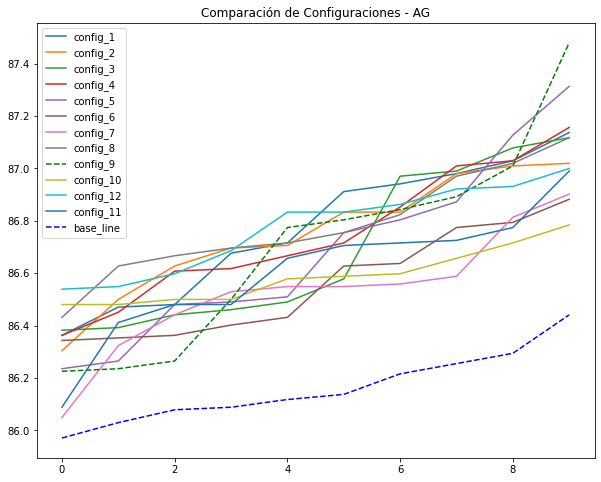

In [15]:
best_key = 'base_line'
ft = -1
for k in all_runs.keys():
    sorted_fitness = sorted(history[k], key=lambda item: item['fitness'], reverse=True)[0]
    if sorted_fitness['fitness'] > ft:
        ft = sorted_fitness['fitness']
        best_key = k

plt.figure(figsize=(10,8))
plt.title('Comparación de Configuraciones - AG')
for key, value in all_runs.items():
    xs = range(len(value))
    ys = sorted([item['fitness']*100 for item in value])
    if key == 'base_line': 
        plt.plot(xs, ys, 'b--', label=key)
    elif key == best_key:
        plt.plot(xs, ys, 'g--', label=key)
    else:
        plt.plot(xs, ys, '-', label=key)

plt.legend()
plt.show()